In [1]:
import rasterio as rio
import rioxarray as rxr
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns

In [3]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))

from config import raw_files, processed_files

In [4]:
file_path = processed_files["elevation"] / "Elevation_DZ_TN.tif"
elevation_data = rxr.open_rasterio(file_path, masked=True).squeeze()

### Data Preprocessing
after visulizing the eda, i observed that the outliers are not errors, so we can not simply remove them, instead we can use other methods like log transformation of binning, log transformation is useful when the data is highly skewed, so its not a good fit here, instead i choosed bining (equal width)

In [5]:
# Convert xarray to pandas DataFrame
elevation_df = elevation_data.to_dataframe(name='elevation').reset_index()


In [6]:
elevation_df.head()

,y,x,band,spatial_ref,elevation
0,37.560278,-8.673056,1,0,NaN
1,37.560278,-8.668889,1,0,NaN
2,37.560278,-8.664722,1,0,NaN
3,37.560278,-8.660556,1,0,NaN
4,37.560278,-8.656389,1,0,NaN


removed spatial_ref and band (useless infos)

In [7]:
elevation_df = elevation_df[['x', 'y', 'elevation']]
elevation_df.head()

,x,y,elevation
0,-8.673056,37.560278,NaN
1,-8.668889,37.560278,NaN
2,-8.664722,37.560278,NaN
3,-8.660556,37.560278,NaN
4,-8.656389,37.560278,NaN


In [8]:
elevation_df = elevation_df.rename(columns={'x': 'longitude', 'y': 'latitude'})
elevation_df.head()

,longitude,latitude,elevation
0,-8.673056,37.560278,NaN
1,-8.668889,37.560278,NaN
2,-8.664722,37.560278,NaN
3,-8.660556,37.560278,NaN
4,-8.656389,37.560278,NaN


remove missing values because they are out of the algeria,tunisia's zones

In [9]:

kept_df = elevation_df[elevation_df['elevation'].notna()]

In [10]:
kept_df.head()

,longitude,latitude,elevation
9191,8.956111,37.556111,0.0
14149,8.947778,37.551944,0.0
29028,8.943611,37.539444,1.0
29029,8.947778,37.539444,0.0
33987,8.939444,37.535278,0.0


In [11]:
print(kept_df.head(10))
print(len(kept_df))

       longitude   latitude  elevation
9191    8.956111  37.556111        0.0
14149   8.947778  37.551944        0.0
29028   8.943611  37.539444        1.0
29029   8.947778  37.539444        0.0
33987   8.939444  37.535278        0.0
33988   8.943611  37.535278       12.0
33989   8.947778  37.535278        0.0
38942   8.918611  37.531111        0.0
38943   8.922778  37.531111        0.0
38944   8.926944  37.531111        0.0
13119560


im gonna use Sturges Formula for binning:

In [12]:
import numpy as np
import pandas as pd

# Suppose your DataFrame is called elevation_df and the column is 'elevation'
n = len(kept_df['elevation'])

# Sturges' formula
num_bins = int(1 + 3.322 * np.log10(n))

print(f"Number of bins (Sturges formula): {num_bins}")

Number of bins (Sturges formula): 24


In [13]:
kept_df['elevation_bin'] = pd.cut(kept_df['elevation'], bins=num_bins)
print(kept_df.head())

       longitude   latitude  elevation     elevation_bin
9191    8.956111  37.556111        0.0  (-90.958, 65.25]
14149   8.947778  37.551944        0.0  (-90.958, 65.25]
29028   8.943611  37.539444        1.0  (-90.958, 65.25]
29029   8.947778  37.539444        0.0  (-90.958, 65.25]
33987   8.939444  37.535278        0.0  (-90.958, 65.25]


C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_16180\1433061554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df['elevation_bin'] = pd.cut(kept_df['elevation'], bins=num_bins)


smoothing by mean

In [16]:
# Smooth by bin mean
bin_means = kept_df.groupby('elevation_bin')['elevation'].mean()
kept_df['elevation_smoothed'] = kept_df['elevation_bin'].map(bin_means)
kept_df['elevation_smoothed']

C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_16180\724912527.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = kept_df.groupby('elevation_bin')['elevation'].mean()
C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_16180\724912527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df['elevation_smoothed'] = kept_df['elevation_bin'].map(bin_means)


9191         25.104313
14149        25.104313
29028        25.104313
29029        25.104313
33987        25.104313
               ...    
22139363    450.934296
22139364    450.934296
22139365    450.934296
22139366    450.934296
22144322    450.934296
Name: elevation_smoothed, Length: 13119560, dtype: float32

In [ ]:
# Get bin edges
bins = pd.cut(kept_df['elevation'], bins=num_bins)

# Replace with lower boundaries
kept_df['elevation_smoothed_edges'] = bins.apply(lambda x: x.left)

# Or replace with upper boundaries
kept_df['elevation_smoothed_edges'] = bins.apply(lambda x: x.right)
kept_df['elevation_smoothed_edges'].head()


C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_16180\201055981.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df['elevation_smoothed_edges'] = bins.apply(lambda x: x.right)


[65.250, 221.458, 377.667, 533.875, 690.083, ..., 2408.375, -715.792, 2564.583, 2720.792, 2877.000]
Length: 20
Categories (24, float64): [-715.792 < -559.583 < -403.375 < -247.167 ... 2408.375 < 2564.583 < 2720.792 < 2877.000]

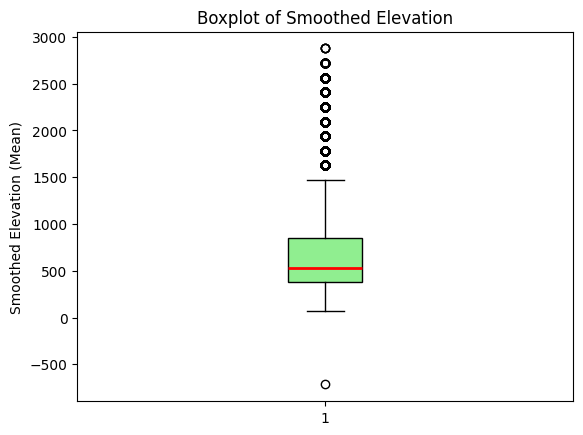

In [24]:
plt.boxplot(kept_df['elevation_smoothed_edges'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation")
plt.ylabel("Smoothed Elevation (Mean)")
plt.show()

using here equal-depth

In [27]:
# Compute quantile bins (edges)
_, bin_edges = pd.qcut(kept_df["elevation"], q=4, retbins=True, duplicates="drop")

print("Equal-frequency bin edges:", bin_edges)

Equal-frequency bin edges: [-872.  312.  464.  698. 2877.]


In [28]:
# Smooth by nearest bin boundary
def smooth_by_boundary(x, bins):
    for i in range(1, len(bins)):
        if bins[i-1] <= x <= bins[i]:
            # Replace with the midpoint of the bin
            return (bins[i-1] + bins[i]) / 2
    return x

kept_df["elevation_smoothed"] = kept_df["elevation"].apply(lambda x: smooth_by_boundary(x, bin_edges))


C:\Users\BIG BOX\AppData\Local\Temp\ipykernel_16180\3641879082.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kept_df["elevation_smoothed"] = kept_df["elevation"].apply(lambda x: smooth_by_boundary(x, bin_edges))


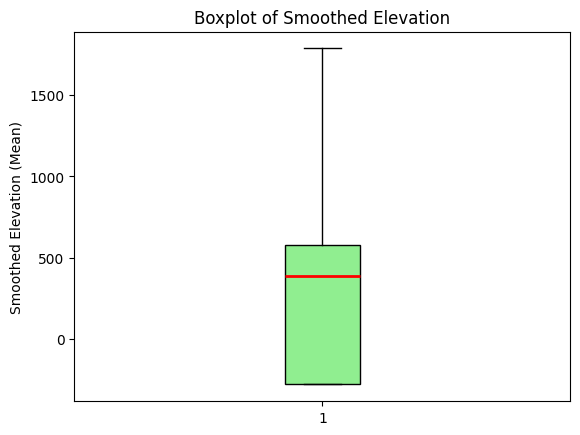

In [29]:
plt.boxplot(kept_df['elevation_smoothed'], vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Boxplot of Smoothed Elevation")
plt.ylabel("Smoothed Elevation (Mean)")
plt.show()

Text(0, 0.5, 'Frequency')

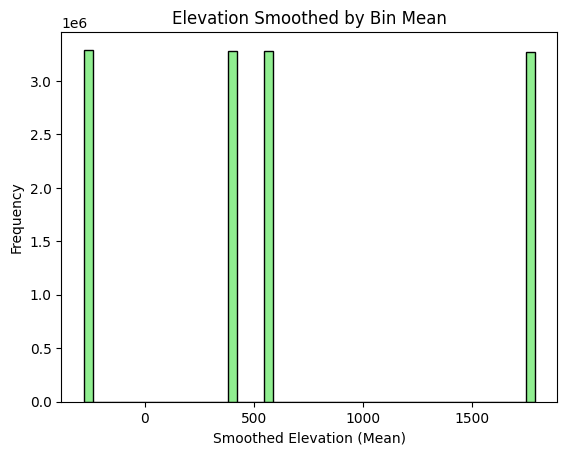

In [30]:
plt.hist(kept_df['elevation_smoothed'], bins=50, color='lightgreen', edgecolor='black')
plt.title("Elevation Smoothed by Bin Mean")
plt.xlabel("Smoothed Elevation (Mean)")
plt.ylabel("Frequency")

In [31]:
kept_df.head()

,longitude,latitude,elevation,elevation_bin,elevation_smoothed,elevation_smoothed_edges
9191,8.956111,37.556111,0.0,"(-90.958, 65.25]",-280.0,65.25
14149,8.947778,37.551944,0.0,"(-90.958, 65.25]",-280.0,65.25
29028,8.943611,37.539444,1.0,"(-90.958, 65.25]",-280.0,65.25
29029,8.947778,37.539444,0.0,"(-90.958, 65.25]",-280.0,65.25
33987,8.939444,37.535278,0.0,"(-90.958, 65.25]",-280.0,65.25
